In [1]:
# installs & imports
!pip install -q torch torchvision tqdm einops

import math, os, random, time
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import LambdaLR
from torchvision.transforms import AutoAugmentPolicy

from einops import rearrange

In [3]:
# config
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)

cfg = {
    "image_size": 32,
    "patch_size": 4,
    "in_channels": 3,
    "num_classes": 100,
    "emb_dim": 384,     # smaller, regularizes better
    "num_heads": 6,
    "depth": 8,
    "mlp_ratio": 4.0,
    "drop": 0.1,
    "drop_path": 0.1,   # stochastic depth (important)
    "batch_size": 128,
    "epochs": 200,      # 200–300 is enough with cosine LR
    "lr": 3e-4,
    "weight_decay": 0.05,
    "warmup_epochs": 5,
    "label_smoothing": 0.1,
    "ema_decay": 0.9999,
    "seed": 42,
    "use_token_drop": True,
    "initial_drop_ratio": 0.0,     # drop nothing in first epoch
    "final_drop_ratio": 0.35,      # drop 35% of tokens late in training
    "ctd_start_epoch": 20,         # begin curriculum after 20 epochs
    "ctd_end_epoch": 160,          # curriculum ends here
    "ctd_gamma": 1.5             # >1 = slow early, stronger later
}

device: mps


In [4]:
# reproducibility
torch.manual_seed(cfg["seed"])
random.seed(cfg["seed"])

In [5]:
# Dataset
mean = (0.5071, 0.4867, 0.4408)
std  = (0.2675, 0.2565, 0.2761)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),  # Move ToTensor before RandomErasing
    transforms.RandomErasing(p=0.25, value='random'),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.CIFAR100(root="data", train=True, download=True, transform=train_transform)
test_ds  = datasets.CIFAR100(root="data", train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

In [6]:
# CTD_ViT model implementation

class ConvPatchEmbed(nn.Module):
    def __init__(self, in_chans=3, embed_dim=384):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_chans, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, embed_dim, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(inplace=True),
        )
        # n_patches = (32/4)^2 = 8*8 = 64
        self.n_patches = (32 // 4) ** 2

    def forward(self, x):
        x = self.conv(x)          # (B, E, 8, 8)
        x = x.flatten(2)          # (B, E, N)
        x = x.transpose(1, 2)     # (B, N, E)
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, drop=0.):
        super().__init__()
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, return_attn=False):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)\
                         .permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # (B, heads, N, head_dim)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)        # (B, heads, N, N)
        attn_dropped = self.attn_drop(attn)
        x = (attn_dropped @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        if return_attn:
            return x, attn
        return x

class _StochasticDepth(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
    def forward(self, x):
        if not self.training or self.p == 0.:
            return x
        keep = torch.rand(x.shape[0], 1, 1, device=x.device) >= self.p
        return x * keep / (1 - self.p)

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., drop=0., attn_drop=0., drop_path=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads,
                              attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = nn.Identity() if drop_path == 0. else _StochasticDepth(drop_path)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim*mlp_ratio), drop=drop)

    def _get_drop_ratio(self, epoch: int):
        start = cfg.get("ctd_start_epoch", 0)
        end   = cfg.get("ctd_end_epoch", cfg["epochs"])
        init  = cfg.get("ctd_initial_drop", 0.0)
        final = cfg.get("ctd_final_drop", 0.5)
        gamma = cfg.get("ctd_gamma", 1.0)

        if epoch is None:
            return 0.0
        if epoch < start:
            return init
        if epoch >= end:
            return final

        p = (epoch - start) / max(1, end - start)
        p = p ** gamma
        return init + p * (final - init)

    def forward(self, x, epoch=None):
        use_ctd = self.training and cfg.get("use_token_drop", False) and epoch is not None

        if not use_ctd:
            # standard transformer block
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x

        # ===== Curriculum Token Drop path =====
        drop_ratio = self._get_drop_ratio(epoch)
        if drop_ratio <= 1e-6:
            # effectively no drop
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x

        B, N_plus_1, C = x.shape
        if N_plus_1 <= 1:
            # no patches
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x

        # norm and attention
        normed = self.norm1(x)
        attn_out, attn_weights = self.attn(normed, return_attn=True)  # attn_weights: (B, heads, N, N)

        # CLS -> patch saliency: mean over heads
        # saliency for each patch token, shape: (B, N_patches)
        saliency = attn_weights.mean(dim=1)[:, 0, 1:]   # (B, N_patches)
        N_patches = saliency.shape[1]

        keep = max(1, int(N_patches * (1.0 - drop_ratio)))
        if keep >= N_patches:
            # nothing to drop
            x = x + self.drop_path(attn_out)
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x

        # pick top-k salient tokens
        _, idx = torch.topk(saliency, k=keep, dim=1, largest=True, sorted=False)  # (B, keep)

        # separate cls and patch tokens
        cls_x = x[:, :1, :]             # (B, 1, C)
        tokens_x = x[:, 1:, :]          # (B, N_patches, C)

        cls_attn = attn_out[:, :1, :]   # (B, 1, C)
        tokens_attn = attn_out[:, 1:, :]# (B, N_patches, C)

        # gather along tokens dimension using idx
        idx_expanded = idx.unsqueeze(-1).expand(-1, -1, C)  # (B, keep, C)

        kept_x = torch.gather(tokens_x, 1, idx_expanded)       # (B, keep, C)
        kept_attn = torch.gather(tokens_attn, 1, idx_expanded) # (B, keep, C)

        x_new = torch.cat([cls_x, kept_x], dim=1)              # (B, 1+keep, C)
        attn_new = torch.cat([cls_attn, kept_attn], dim=1)     # (B, 1+keep, C)

        # residual + MLP
        x_new = x_new + self.drop_path(attn_new)
        x_new = x_new + self.drop_path(self.mlp(self.norm2(x_new)))
        return x_new

class ViT(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.patch_embed = ConvPatchEmbed(cfg["in_channels"], cfg["emb_dim"])
        n_patches = self.patch_embed.n_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, cfg["emb_dim"]))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + n_patches, cfg["emb_dim"]))
        self.pos_drop = nn.Dropout(p=cfg["drop"])

        dpr = [x.item() for x in torch.linspace(0, cfg.get("drop_path", 0.2), cfg["depth"])]
        self.blocks = nn.ModuleList([
            Block(cfg["emb_dim"], num_heads=cfg["num_heads"],
                  mlp_ratio=cfg["mlp_ratio"], drop=cfg["drop"], drop_path=dpr[i])
            for i in range(cfg["depth"])
        ])
        self.norm = nn.LayerNorm(cfg["emb_dim"])
        self.head = nn.Linear(cfg["emb_dim"], cfg["num_classes"])

        nn.init.trunc_normal_(self.pos_embed, std=.02)
        nn.init.trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.zeros_(m.bias)
            nn.init.ones_(m.weight)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if getattr(m, "bias", None) is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x, epoch=None):
        B = x.shape[0]
        x = self.patch_embed(x)             # (B, N, E)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)   # (B, 1+N, E)
        # Note: pos_embed was initialized for 1+64 tokens; if we drop tokens,
        # it's okay because position embedding acts as a prior, not a strict index.
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x, epoch=epoch)

        x = self.norm(x)
        cls = x[:, 0]
        out = self.head(cls)
        return out

In [7]:
def warmup_lambda(epoch):
    if epoch < cfg["warmup_epochs"]:
        return float(epoch) / float(max(1, cfg["warmup_epochs"]))
    return 1.0

model = ViT(cfg).to(device)

# optional EMA
try:
    from torch_ema import ExponentialMovingAverage
    ema = ExponentialMovingAverage(model.parameters(), decay=cfg["ema_decay"])
except ImportError:
    ema = None

optimizer = AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=cfg["epochs"] - cfg["warmup_epochs"],
    eta_min=1e-5
)

criterion = nn.CrossEntropyLoss(label_smoothing=cfg["label_smoothing"])

In [8]:
# train & eval loops
def train_one_epoch(model, loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    pbar = tqdm(loader, desc=f"Train Epoch {epoch}")
    for images, targets in pbar:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images, epoch=epoch)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if ema is not None:
            ema.update()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()
        pbar.set_postfix(loss=running_loss/total, acc=100.*correct/total)
    return running_loss/total, 100.*correct/total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    losses = 0.0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)  # epoch not needed in eval
        loss = criterion(outputs, targets)
        losses += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()
    return losses/total, 100.*correct/total

In [9]:
# main training loop
best_acc = 0.0
total_epochs = cfg["epochs"]

import csv, pickle

history = []
csv_file = "CTD_ViT_metrics.csv"
with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "lr"])

for epoch in range(total_epochs):

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, epoch)
    val_loss, val_acc = evaluate(model, test_loader)

    # LR step AFTER optimizer
    if epoch < cfg["warmup_epochs"]:
        warmup_scheduler.step()
    else:
        cosine_scheduler.step()

    lr = optimizer.param_groups[0]["lr"]

    print(f"Epoch {epoch:03d}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.2f}% | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.2f}% | lr={lr:.6f}")

    history.append((epoch, train_loss, train_acc, val_loss, val_acc, lr))
    with open(csv_file, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc, lr])

    if val_acc > best_acc:
        best_acc = val_acc
        checkpoint = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "warmup_scheduler_state": warmup_scheduler.state_dict(),
            "cosine_scheduler_state": cosine_scheduler.state_dict(),
            "best_acc": best_acc,
            "history": history,
        }
        torch.save(checkpoint, "best_CTD_ViT_CIFAR100_checkpoint.pth")
        print(f"Saved new best CTD model: {best_acc:.2f}%")

print("Best CTD test accuracy: %.2f%%" % best_acc)

with open("CTD_ViT_history.pkl", "wb") as f:
    pickle.dump(history, f)
print("Saved history to CTD_ViT_history.pkl & CTD_ViT_metrics.csv")


Train Epoch 0:   0%|                                    | 0/391 [00:00<?, ?it/s]/Users/aumkeshchaudhary/anaconda3/envs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train Epoch 0: 100%|█████| 391/391 [02:43<00:00,  2.39it/s, acc=1.01, loss=5.41]


Epoch 000: train_loss=5.4139 train_acc=1.01% | val_loss=5.3974 val_acc=0.90% | lr=0.000060
Saved new best CTD model: 0.90%


Train Epoch 1: 100%|█████| 391/391 [02:43<00:00,  2.40it/s, acc=4.47, loss=4.43]


Epoch 001: train_loss=4.4323 train_acc=4.47% | val_loss=3.9493 val_acc=11.81% | lr=0.000120
Saved new best CTD model: 11.81%


Train Epoch 2: 100%|█████| 391/391 [02:43<00:00,  2.40it/s, acc=7.65, loss=4.19]


Epoch 002: train_loss=4.1919 train_acc=7.65% | val_loss=3.7370 val_acc=16.14% | lr=0.000180
Saved new best CTD model: 16.14%


Train Epoch 3: 100%|███████| 391/391 [02:42<00:00,  2.40it/s, acc=11, loss=4.01]


Epoch 003: train_loss=4.0078 train_acc=10.96% | val_loss=3.5040 val_acc=20.48% | lr=0.000240
Saved new best CTD model: 20.48%


Train Epoch 4: 100%|█████| 391/391 [02:42<00:00,  2.40it/s, acc=13.5, loss=3.87]


Epoch 004: train_loss=3.8655 train_acc=13.48% | val_loss=3.3274 val_acc=24.05% | lr=0.000300
Saved new best CTD model: 24.05%


Train Epoch 5: 100%|█████| 391/391 [02:42<00:00,  2.40it/s, acc=16.1, loss=3.75]


Epoch 005: train_loss=3.7495 train_acc=16.07% | val_loss=3.2264 val_acc=26.98% | lr=0.000300
Saved new best CTD model: 26.98%


Train Epoch 6: 100%|█████| 391/391 [02:42<00:00,  2.41it/s, acc=18.5, loss=3.63]


Epoch 006: train_loss=3.6295 train_acc=18.50% | val_loss=3.0692 val_acc=30.81% | lr=0.000300
Saved new best CTD model: 30.81%


Train Epoch 7: 100%|█████| 391/391 [02:42<00:00,  2.41it/s, acc=20.8, loss=3.53]


Epoch 007: train_loss=3.5330 train_acc=20.77% | val_loss=2.9950 val_acc=32.01% | lr=0.000300
Saved new best CTD model: 32.01%


Train Epoch 8: 100%|█████| 391/391 [02:42<00:00,  2.41it/s, acc=22.5, loss=3.45]


Epoch 008: train_loss=3.4507 train_acc=22.47% | val_loss=2.9784 val_acc=33.47% | lr=0.000300
Saved new best CTD model: 33.47%


Train Epoch 9: 100%|█████| 391/391 [02:42<00:00,  2.41it/s, acc=24.1, loss=3.39]


Epoch 009: train_loss=3.3852 train_acc=24.07% | val_loss=2.8984 val_acc=35.19% | lr=0.000300
Saved new best CTD model: 35.19%


Train Epoch 10: 100%|████| 391/391 [02:41<00:00,  2.41it/s, acc=25.7, loss=3.32]


Epoch 010: train_loss=3.3195 train_acc=25.73% | val_loss=2.8521 val_acc=36.09% | lr=0.000299
Saved new best CTD model: 36.09%


Train Epoch 11: 100%|████| 391/391 [02:43<00:00,  2.40it/s, acc=26.5, loss=3.27]


Epoch 011: train_loss=3.2711 train_acc=26.50% | val_loss=2.7891 val_acc=38.32% | lr=0.000299
Saved new best CTD model: 38.32%


Train Epoch 12: 100%|████| 391/391 [02:41<00:00,  2.41it/s, acc=28.1, loss=3.22]


Epoch 012: train_loss=3.2187 train_acc=28.06% | val_loss=2.7116 val_acc=40.62% | lr=0.000299
Saved new best CTD model: 40.62%


Train Epoch 13: 100%|████| 391/391 [02:42<00:00,  2.41it/s, acc=29.3, loss=3.16]


Epoch 013: train_loss=3.1612 train_acc=29.35% | val_loss=2.6720 val_acc=40.99% | lr=0.000298
Saved new best CTD model: 40.99%


Train Epoch 14: 100%|████| 391/391 [02:41<00:00,  2.41it/s, acc=30.3, loss=3.12]


Epoch 014: train_loss=3.1162 train_acc=30.27% | val_loss=2.6167 val_acc=43.43% | lr=0.000298
Saved new best CTD model: 43.43%


Train Epoch 15: 100%|████| 391/391 [02:43<00:00,  2.39it/s, acc=31.6, loss=3.07]


Epoch 015: train_loss=3.0729 train_acc=31.57% | val_loss=2.5616 val_acc=44.34% | lr=0.000298
Saved new best CTD model: 44.34%


Train Epoch 16: 100%|████| 391/391 [02:42<00:00,  2.41it/s, acc=32.6, loss=3.03]


Epoch 016: train_loss=3.0286 train_acc=32.64% | val_loss=2.5854 val_acc=43.77% | lr=0.000297


Train Epoch 17: 100%|████| 391/391 [02:42<00:00,  2.41it/s, acc=33.5, loss=2.99]


Epoch 017: train_loss=2.9900 train_acc=33.47% | val_loss=2.5194 val_acc=45.75% | lr=0.000297
Saved new best CTD model: 45.75%


Train Epoch 18: 100%|████| 391/391 [02:42<00:00,  2.41it/s, acc=34.6, loss=2.96]


Epoch 018: train_loss=2.9572 train_acc=34.57% | val_loss=2.5012 val_acc=46.26% | lr=0.000296
Saved new best CTD model: 46.26%


Train Epoch 19: 100%|████| 391/391 [02:42<00:00,  2.41it/s, acc=35.9, loss=2.91]


Epoch 019: train_loss=2.9079 train_acc=35.93% | val_loss=2.4388 val_acc=47.79% | lr=0.000296
Saved new best CTD model: 47.79%


Train Epoch 20: 100%|████| 391/391 [02:42<00:00,  2.41it/s, acc=36.9, loss=2.87]


Epoch 020: train_loss=2.8658 train_acc=36.94% | val_loss=2.4370 val_acc=48.85% | lr=0.000295
Saved new best CTD model: 48.85%


Train Epoch 21: 100%|████| 391/391 [02:51<00:00,  2.29it/s, acc=37.7, loss=2.83]


Epoch 021: train_loss=2.8338 train_acc=37.74% | val_loss=2.4289 val_acc=48.14% | lr=0.000295


Train Epoch 22: 100%|█████| 391/391 [02:47<00:00,  2.33it/s, acc=38.6, loss=2.8]


Epoch 022: train_loss=2.8049 train_acc=38.65% | val_loss=2.4102 val_acc=48.90% | lr=0.000294
Saved new best CTD model: 48.90%


Train Epoch 23: 100%|████| 391/391 [02:47<00:00,  2.33it/s, acc=39.3, loss=2.77]


Epoch 023: train_loss=2.7678 train_acc=39.28% | val_loss=2.3428 val_acc=50.82% | lr=0.000293
Saved new best CTD model: 50.82%


Train Epoch 24: 100%|████| 391/391 [02:47<00:00,  2.33it/s, acc=40.4, loss=2.74]


Epoch 024: train_loss=2.7402 train_acc=40.41% | val_loss=2.3066 val_acc=51.58% | lr=0.000293
Saved new best CTD model: 51.58%


Train Epoch 25: 100%|████| 391/391 [02:47<00:00,  2.33it/s, acc=41.1, loss=2.71]


Epoch 025: train_loss=2.7073 train_acc=41.09% | val_loss=2.2943 val_acc=52.37% | lr=0.000292
Saved new best CTD model: 52.37%


Train Epoch 26: 100%|████| 391/391 [02:47<00:00,  2.33it/s, acc=41.7, loss=2.69]


Epoch 026: train_loss=2.6863 train_acc=41.66% | val_loss=2.2640 val_acc=53.02% | lr=0.000291
Saved new best CTD model: 53.02%


Train Epoch 27: 100%|████| 391/391 [02:47<00:00,  2.33it/s, acc=43.3, loss=2.64]


Epoch 027: train_loss=2.6370 train_acc=43.32% | val_loss=2.2515 val_acc=53.75% | lr=0.000290
Saved new best CTD model: 53.75%


Train Epoch 28: 100%|████| 391/391 [02:47<00:00,  2.33it/s, acc=43.2, loss=2.63]


Epoch 028: train_loss=2.6263 train_acc=43.15% | val_loss=2.2587 val_acc=53.86% | lr=0.000289
Saved new best CTD model: 53.86%


Train Epoch 29: 100%|████| 391/391 [02:47<00:00,  2.33it/s, acc=44.6, loss=2.58]


Epoch 029: train_loss=2.5825 train_acc=44.55% | val_loss=2.2712 val_acc=53.36% | lr=0.000288


Train Epoch 30: 100%|████| 391/391 [02:47<00:00,  2.33it/s, acc=45.3, loss=2.56]


Epoch 030: train_loss=2.5636 train_acc=45.30% | val_loss=2.2118 val_acc=54.71% | lr=0.000287
Saved new best CTD model: 54.71%


Train Epoch 31: 100%|██████| 391/391 [02:47<00:00,  2.33it/s, acc=46, loss=2.53]


Epoch 031: train_loss=2.5326 train_acc=46.01% | val_loss=2.1718 val_acc=55.94% | lr=0.000286
Saved new best CTD model: 55.94%


Train Epoch 32: 100%|█████| 391/391 [02:48<00:00,  2.32it/s, acc=46.8, loss=2.5]


Epoch 032: train_loss=2.5018 train_acc=46.81% | val_loss=2.1451 val_acc=57.43% | lr=0.000285
Saved new best CTD model: 57.43%


Train Epoch 33: 100%|████| 391/391 [02:47<00:00,  2.33it/s, acc=47.1, loss=2.49]


Epoch 033: train_loss=2.4856 train_acc=47.14% | val_loss=2.1668 val_acc=56.24% | lr=0.000284


Train Epoch 34: 100%|████| 391/391 [02:45<00:00,  2.36it/s, acc=48.3, loss=2.45]


Epoch 034: train_loss=2.4525 train_acc=48.32% | val_loss=2.1655 val_acc=56.42% | lr=0.000283


Train Epoch 35: 100%|████| 391/391 [02:41<00:00,  2.42it/s, acc=48.8, loss=2.43]


Epoch 035: train_loss=2.4281 train_acc=48.77% | val_loss=2.1555 val_acc=56.28% | lr=0.000282


Train Epoch 36: 100%|█████| 391/391 [02:39<00:00,  2.46it/s, acc=49.6, loss=2.4]


Epoch 036: train_loss=2.4027 train_acc=49.64% | val_loss=2.1286 val_acc=57.92% | lr=0.000281
Saved new best CTD model: 57.92%


Train Epoch 37: 100%|████| 391/391 [02:38<00:00,  2.46it/s, acc=50.3, loss=2.38]


Epoch 037: train_loss=2.3791 train_acc=50.33% | val_loss=2.1169 val_acc=57.93% | lr=0.000280
Saved new best CTD model: 57.93%


Train Epoch 38: 100%|████| 391/391 [02:38<00:00,  2.46it/s, acc=50.9, loss=2.35]


Epoch 038: train_loss=2.3531 train_acc=50.91% | val_loss=2.1087 val_acc=57.93% | lr=0.000279


Train Epoch 39: 100%|████| 391/391 [02:38<00:00,  2.46it/s, acc=51.7, loss=2.34]


Epoch 039: train_loss=2.3353 train_acc=51.67% | val_loss=2.1066 val_acc=58.42% | lr=0.000278
Saved new best CTD model: 58.42%


Train Epoch 40: 100%|████| 391/391 [02:38<00:00,  2.47it/s, acc=52.3, loss=2.32]


Epoch 040: train_loss=2.3187 train_acc=52.33% | val_loss=2.1001 val_acc=58.73% | lr=0.000276
Saved new best CTD model: 58.73%


Train Epoch 41: 100%|████| 391/391 [02:38<00:00,  2.46it/s, acc=53.3, loss=2.28]


Epoch 041: train_loss=2.2846 train_acc=53.27% | val_loss=2.0900 val_acc=58.96% | lr=0.000275
Saved new best CTD model: 58.96%


Train Epoch 42: 100%|████| 391/391 [02:38<00:00,  2.46it/s, acc=53.8, loss=2.27]


Epoch 042: train_loss=2.2682 train_acc=53.81% | val_loss=2.0832 val_acc=59.83% | lr=0.000274
Saved new best CTD model: 59.83%


Train Epoch 43: 100%|████| 391/391 [02:34<00:00,  2.53it/s, acc=54.4, loss=2.24]


Epoch 043: train_loss=2.2442 train_acc=54.42% | val_loss=2.0718 val_acc=59.73% | lr=0.000272


Train Epoch 44: 100%|████| 391/391 [02:33<00:00,  2.55it/s, acc=54.9, loss=2.22]


Epoch 044: train_loss=2.2216 train_acc=54.91% | val_loss=2.0641 val_acc=59.74% | lr=0.000271


Train Epoch 45: 100%|█████| 391/391 [02:32<00:00,  2.57it/s, acc=55.6, loss=2.2]


Epoch 045: train_loss=2.2016 train_acc=55.63% | val_loss=2.0896 val_acc=59.69% | lr=0.000270


Train Epoch 46: 100%|████| 391/391 [02:29<00:00,  2.61it/s, acc=56.5, loss=2.18]


Epoch 046: train_loss=2.1804 train_acc=56.51% | val_loss=2.0270 val_acc=60.95% | lr=0.000268
Saved new best CTD model: 60.95%


Train Epoch 47: 100%|████| 391/391 [02:29<00:00,  2.62it/s, acc=57.2, loss=2.17]


Epoch 047: train_loss=2.1667 train_acc=57.16% | val_loss=2.0549 val_acc=60.22% | lr=0.000267


Train Epoch 48: 100%|████| 391/391 [02:28<00:00,  2.64it/s, acc=57.3, loss=2.15]


Epoch 048: train_loss=2.1477 train_acc=57.30% | val_loss=2.0526 val_acc=61.05% | lr=0.000265
Saved new best CTD model: 61.05%


Train Epoch 49: 100%|████| 391/391 [02:26<00:00,  2.67it/s, acc=58.1, loss=2.12]


Epoch 049: train_loss=2.1240 train_acc=58.10% | val_loss=2.0400 val_acc=61.12% | lr=0.000264
Saved new best CTD model: 61.12%


Train Epoch 50: 100%|████| 391/391 [02:25<00:00,  2.68it/s, acc=58.6, loss=2.11]


Epoch 050: train_loss=2.1140 train_acc=58.61% | val_loss=2.0503 val_acc=61.05% | lr=0.000262


Train Epoch 51: 100%|████| 391/391 [02:22<00:00,  2.74it/s, acc=59.3, loss=2.08]


Epoch 051: train_loss=2.0831 train_acc=59.27% | val_loss=2.0579 val_acc=60.28% | lr=0.000260


Train Epoch 52: 100%|██████| 391/391 [02:21<00:00,  2.77it/s, acc=60, loss=2.06]


Epoch 052: train_loss=2.0628 train_acc=60.04% | val_loss=2.0193 val_acc=62.16% | lr=0.000259
Saved new best CTD model: 62.16%


Train Epoch 53: 100%|████| 391/391 [02:21<00:00,  2.77it/s, acc=60.6, loss=2.05]


Epoch 053: train_loss=2.0486 train_acc=60.64% | val_loss=2.0498 val_acc=60.75% | lr=0.000257


Train Epoch 54: 100%|████| 391/391 [02:19<00:00,  2.80it/s, acc=60.9, loss=2.03]


Epoch 054: train_loss=2.0288 train_acc=60.95% | val_loss=2.0401 val_acc=61.44% | lr=0.000255


Train Epoch 55: 100%|████| 391/391 [02:19<00:00,  2.80it/s, acc=61.4, loss=2.02]


Epoch 055: train_loss=2.0220 train_acc=61.38% | val_loss=2.0437 val_acc=61.56% | lr=0.000254


Train Epoch 56: 100%|██████| 391/391 [02:15<00:00,  2.88it/s, acc=62, loss=2.01]


Epoch 056: train_loss=2.0050 train_acc=62.04% | val_loss=2.0399 val_acc=61.34% | lr=0.000252


Train Epoch 57: 100%|████| 391/391 [02:14<00:00,  2.90it/s, acc=62.9, loss=1.98]


Epoch 057: train_loss=1.9798 train_acc=62.92% | val_loss=2.0389 val_acc=61.81% | lr=0.000250


Train Epoch 58: 100%|████| 391/391 [02:14<00:00,  2.91it/s, acc=62.9, loss=1.97]


Epoch 058: train_loss=1.9732 train_acc=62.93% | val_loss=2.0275 val_acc=61.90% | lr=0.000249


Train Epoch 59: 100%|████| 391/391 [02:13<00:00,  2.92it/s, acc=63.6, loss=1.95]


Epoch 059: train_loss=1.9481 train_acc=63.59% | val_loss=2.0301 val_acc=62.38% | lr=0.000247
Saved new best CTD model: 62.38%


Train Epoch 60: 100%|████| 391/391 [02:12<00:00,  2.94it/s, acc=64.2, loss=1.93]


Epoch 060: train_loss=1.9329 train_acc=64.22% | val_loss=2.0452 val_acc=62.05% | lr=0.000245


Train Epoch 61: 100%|████| 391/391 [02:10<00:00,  2.99it/s, acc=64.4, loss=1.93]


Epoch 061: train_loss=1.9286 train_acc=64.44% | val_loss=2.0295 val_acc=62.07% | lr=0.000243


Train Epoch 62: 100%|████| 391/391 [02:09<00:00,  3.01it/s, acc=65.1, loss=1.91]


Epoch 062: train_loss=1.9149 train_acc=65.06% | val_loss=2.0094 val_acc=63.00% | lr=0.000241
Saved new best CTD model: 63.00%


Train Epoch 63: 100%|█████| 391/391 [02:09<00:00,  3.03it/s, acc=65.4, loss=1.9]


Epoch 063: train_loss=1.9011 train_acc=65.44% | val_loss=2.0305 val_acc=62.71% | lr=0.000239


Train Epoch 64: 100%|████| 391/391 [02:06<00:00,  3.09it/s, acc=65.8, loss=1.89]


Epoch 064: train_loss=1.8920 train_acc=65.82% | val_loss=2.0106 val_acc=63.01% | lr=0.000237
Saved new best CTD model: 63.01%


Train Epoch 65: 100%|████| 391/391 [02:05<00:00,  3.11it/s, acc=66.2, loss=1.87]


Epoch 065: train_loss=1.8735 train_acc=66.15% | val_loss=2.0381 val_acc=61.96% | lr=0.000235


Train Epoch 66: 100%|████| 391/391 [02:04<00:00,  3.14it/s, acc=66.9, loss=1.86]


Epoch 066: train_loss=1.8563 train_acc=66.87% | val_loss=2.0572 val_acc=62.65% | lr=0.000233


Train Epoch 67: 100%|████| 391/391 [02:04<00:00,  3.14it/s, acc=67.4, loss=1.84]


Epoch 067: train_loss=1.8430 train_acc=67.38% | val_loss=2.0315 val_acc=62.20% | lr=0.000232


Train Epoch 68: 100%|████| 391/391 [02:02<00:00,  3.18it/s, acc=67.4, loss=1.84]


Epoch 068: train_loss=1.8355 train_acc=67.40% | val_loss=2.0288 val_acc=62.82% | lr=0.000230


Train Epoch 69: 100%|████| 391/391 [02:00<00:00,  3.23it/s, acc=68.2, loss=1.82]


Epoch 069: train_loss=1.8220 train_acc=68.19% | val_loss=1.9912 val_acc=63.38% | lr=0.000228
Saved new best CTD model: 63.38%


Train Epoch 70: 100%|████| 391/391 [01:59<00:00,  3.28it/s, acc=68.4, loss=1.81]


Epoch 070: train_loss=1.8150 train_acc=68.35% | val_loss=2.0227 val_acc=62.91% | lr=0.000225


Train Epoch 71: 100%|█████| 391/391 [01:57<00:00,  3.32it/s, acc=68.6, loss=1.8]


Epoch 071: train_loss=1.7986 train_acc=68.64% | val_loss=2.0116 val_acc=63.17% | lr=0.000223


Train Epoch 72: 100%|████| 391/391 [01:57<00:00,  3.33it/s, acc=69.1, loss=1.79]


Epoch 072: train_loss=1.7862 train_acc=69.11% | val_loss=2.0153 val_acc=63.33% | lr=0.000221


Train Epoch 73: 100%|████| 391/391 [01:56<00:00,  3.36it/s, acc=69.2, loss=1.79]


Epoch 073: train_loss=1.7890 train_acc=69.15% | val_loss=2.0274 val_acc=63.28% | lr=0.000219


Train Epoch 74: 100%|████| 391/391 [01:56<00:00,  3.36it/s, acc=69.9, loss=1.76]


Epoch 074: train_loss=1.7615 train_acc=69.93% | val_loss=2.0193 val_acc=63.44% | lr=0.000217
Saved new best CTD model: 63.44%


Train Epoch 75: 100%|██████| 391/391 [01:54<00:00,  3.41it/s, acc=70, loss=1.76]


Epoch 075: train_loss=1.7591 train_acc=69.98% | val_loss=1.9956 val_acc=63.99% | lr=0.000215
Saved new best CTD model: 63.99%


Train Epoch 76: 100%|████| 391/391 [01:52<00:00,  3.47it/s, acc=70.5, loss=1.75]


Epoch 076: train_loss=1.7487 train_acc=70.49% | val_loss=2.0040 val_acc=63.98% | lr=0.000213


Train Epoch 77: 100%|████| 391/391 [01:51<00:00,  3.51it/s, acc=70.8, loss=1.74]


Epoch 077: train_loss=1.7386 train_acc=70.76% | val_loss=1.9949 val_acc=63.59% | lr=0.000211


Train Epoch 78: 100%|██████| 391/391 [01:50<00:00,  3.54it/s, acc=71, loss=1.73]


Epoch 078: train_loss=1.7300 train_acc=70.97% | val_loss=2.0061 val_acc=63.41% | lr=0.000209


Train Epoch 79: 100%|████| 391/391 [01:50<00:00,  3.54it/s, acc=71.8, loss=1.71]


Epoch 079: train_loss=1.7065 train_acc=71.77% | val_loss=2.0264 val_acc=63.21% | lr=0.000206


Train Epoch 80: 100%|████| 391/391 [01:49<00:00,  3.56it/s, acc=71.7, loss=1.71]


Epoch 080: train_loss=1.7120 train_acc=71.72% | val_loss=2.0172 val_acc=63.32% | lr=0.000204


Train Epoch 81: 100%|█████| 391/391 [01:48<00:00,  3.62it/s, acc=72.1, loss=1.7]


Epoch 081: train_loss=1.6991 train_acc=72.07% | val_loss=2.0271 val_acc=62.98% | lr=0.000202


Train Epoch 82: 100%|█████| 391/391 [01:47<00:00,  3.63it/s, acc=72.2, loss=1.7]


Epoch 082: train_loss=1.6960 train_acc=72.21% | val_loss=2.0179 val_acc=63.39% | lr=0.000200


Train Epoch 83: 100%|██████| 391/391 [01:46<00:00,  3.68it/s, acc=73, loss=1.67]


Epoch 083: train_loss=1.6739 train_acc=72.96% | val_loss=2.0015 val_acc=63.83% | lr=0.000198


Train Epoch 84: 100%|████| 391/391 [01:46<00:00,  3.67it/s, acc=73.2, loss=1.67]


Epoch 084: train_loss=1.6696 train_acc=73.15% | val_loss=1.9964 val_acc=64.49% | lr=0.000195
Saved new best CTD model: 64.49%


Train Epoch 85: 100%|████| 391/391 [01:45<00:00,  3.72it/s, acc=73.1, loss=1.67]


Epoch 085: train_loss=1.6707 train_acc=73.14% | val_loss=1.9970 val_acc=63.87% | lr=0.000193


Train Epoch 86: 100%|████| 391/391 [01:42<00:00,  3.83it/s, acc=73.1, loss=1.66]


Epoch 086: train_loss=1.6642 train_acc=73.13% | val_loss=2.0208 val_acc=63.69% | lr=0.000191


Train Epoch 87: 100%|████| 391/391 [01:41<00:00,  3.84it/s, acc=73.5, loss=1.66]


Epoch 087: train_loss=1.6612 train_acc=73.50% | val_loss=1.9886 val_acc=64.21% | lr=0.000189


Train Epoch 88: 100%|████| 391/391 [01:41<00:00,  3.84it/s, acc=73.9, loss=1.65]


Epoch 088: train_loss=1.6496 train_acc=73.93% | val_loss=2.0050 val_acc=63.78% | lr=0.000186


Train Epoch 89: 100%|████| 391/391 [01:39<00:00,  3.93it/s, acc=74.5, loss=1.63]


Epoch 089: train_loss=1.6257 train_acc=74.49% | val_loss=2.0059 val_acc=64.21% | lr=0.000184


Train Epoch 90: 100%|████| 391/391 [01:41<00:00,  3.87it/s, acc=74.3, loss=1.64]


Epoch 090: train_loss=1.6368 train_acc=74.33% | val_loss=2.0134 val_acc=64.42% | lr=0.000182


Train Epoch 91: 100%|████| 391/391 [01:39<00:00,  3.94it/s, acc=74.9, loss=1.62]


Epoch 091: train_loss=1.6162 train_acc=74.86% | val_loss=2.0045 val_acc=63.99% | lr=0.000179


Train Epoch 92: 100%|████| 391/391 [01:39<00:00,  3.94it/s, acc=75.1, loss=1.61]


Epoch 092: train_loss=1.6118 train_acc=75.11% | val_loss=1.9925 val_acc=64.48% | lr=0.000177


Train Epoch 93: 100%|██████| 391/391 [01:37<00:00,  4.00it/s, acc=75, loss=1.61]


Epoch 093: train_loss=1.6108 train_acc=74.98% | val_loss=2.0156 val_acc=64.04% | lr=0.000175


Train Epoch 94: 100%|█████| 391/391 [01:37<00:00,  4.02it/s, acc=75.1, loss=1.6]


Epoch 094: train_loss=1.6024 train_acc=75.13% | val_loss=1.9896 val_acc=64.44% | lr=0.000172


Train Epoch 95: 100%|████| 391/391 [01:34<00:00,  4.12it/s, acc=75.5, loss=1.59]


Epoch 095: train_loss=1.5941 train_acc=75.55% | val_loss=2.0106 val_acc=64.45% | lr=0.000170


Train Epoch 96: 100%|████| 391/391 [01:34<00:00,  4.12it/s, acc=75.8, loss=1.58]


Epoch 096: train_loss=1.5823 train_acc=75.83% | val_loss=1.9880 val_acc=64.70% | lr=0.000168
Saved new best CTD model: 64.70%


Train Epoch 97: 100%|████| 391/391 [01:32<00:00,  4.23it/s, acc=75.7, loss=1.59]


Epoch 097: train_loss=1.5873 train_acc=75.66% | val_loss=1.9792 val_acc=64.80% | lr=0.000166
Saved new best CTD model: 64.80%


Train Epoch 98: 100%|████| 391/391 [01:32<00:00,  4.22it/s, acc=76.2, loss=1.57]


Epoch 098: train_loss=1.5749 train_acc=76.23% | val_loss=2.0110 val_acc=64.18% | lr=0.000163


Train Epoch 99: 100%|████| 391/391 [01:32<00:00,  4.22it/s, acc=76.7, loss=1.56]


Epoch 099: train_loss=1.5644 train_acc=76.66% | val_loss=1.9797 val_acc=64.98% | lr=0.000161
Saved new best CTD model: 64.98%


Train Epoch 100: 100%|███| 391/391 [01:33<00:00,  4.19it/s, acc=76.6, loss=1.56]


Epoch 100: train_loss=1.5641 train_acc=76.56% | val_loss=1.9790 val_acc=65.38% | lr=0.000159
Saved new best CTD model: 65.38%


Train Epoch 101: 100%|███| 391/391 [01:31<00:00,  4.29it/s, acc=77.1, loss=1.55]


Epoch 101: train_loss=1.5511 train_acc=77.07% | val_loss=1.9821 val_acc=64.96% | lr=0.000156


Train Epoch 102: 100%|███| 391/391 [01:30<00:00,  4.30it/s, acc=77.1, loss=1.55]


Epoch 102: train_loss=1.5471 train_acc=77.13% | val_loss=1.9816 val_acc=65.14% | lr=0.000154


Train Epoch 103: 100%|███| 391/391 [01:29<00:00,  4.38it/s, acc=77.3, loss=1.54]


Epoch 103: train_loss=1.5351 train_acc=77.33% | val_loss=1.9833 val_acc=65.11% | lr=0.000151


Train Epoch 104: 100%|███| 391/391 [01:28<00:00,  4.41it/s, acc=77.3, loss=1.54]


Epoch 104: train_loss=1.5413 train_acc=77.31% | val_loss=1.9904 val_acc=64.99% | lr=0.000149


Train Epoch 105: 100%|███| 391/391 [01:26<00:00,  4.52it/s, acc=77.5, loss=1.53]


Epoch 105: train_loss=1.5307 train_acc=77.55% | val_loss=1.9771 val_acc=65.27% | lr=0.000147


Train Epoch 106: 100%|███| 391/391 [01:25<00:00,  4.55it/s, acc=78.2, loss=1.52]


Epoch 106: train_loss=1.5176 train_acc=78.17% | val_loss=1.9845 val_acc=64.86% | lr=0.000144


Train Epoch 107: 100%|███| 391/391 [01:26<00:00,  4.51it/s, acc=77.9, loss=1.52]


Epoch 107: train_loss=1.5216 train_acc=77.91% | val_loss=1.9863 val_acc=65.03% | lr=0.000142


Train Epoch 108: 100%|███| 391/391 [01:26<00:00,  4.54it/s, acc=78.4, loss=1.51]


Epoch 108: train_loss=1.5063 train_acc=78.41% | val_loss=1.9898 val_acc=65.10% | lr=0.000140


Train Epoch 109: 100%|███| 391/391 [01:26<00:00,  4.50it/s, acc=77.9, loss=1.52]


Epoch 109: train_loss=1.5177 train_acc=77.91% | val_loss=1.9841 val_acc=65.36% | lr=0.000138


Train Epoch 110: 100%|███| 391/391 [01:24<00:00,  4.64it/s, acc=78.4, loss=1.51]


Epoch 110: train_loss=1.5054 train_acc=78.37% | val_loss=1.9526 val_acc=66.02% | lr=0.000135
Saved new best CTD model: 66.02%


Train Epoch 111: 100%|████| 391/391 [01:23<00:00,  4.66it/s, acc=78.4, loss=1.5]


Epoch 111: train_loss=1.5046 train_acc=78.41% | val_loss=1.9741 val_acc=65.19% | lr=0.000133


Train Epoch 112: 100%|███| 391/391 [01:22<00:00,  4.75it/s, acc=78.9, loss=1.49]


Epoch 112: train_loss=1.4911 train_acc=78.90% | val_loss=1.9700 val_acc=65.27% | lr=0.000131


Train Epoch 113: 100%|█████| 391/391 [01:21<00:00,  4.79it/s, acc=79, loss=1.48]


Epoch 113: train_loss=1.4817 train_acc=79.03% | val_loss=1.9654 val_acc=65.26% | lr=0.000128


Train Epoch 114: 100%|███| 391/391 [01:19<00:00,  4.91it/s, acc=79.2, loss=1.49]


Epoch 114: train_loss=1.4857 train_acc=79.16% | val_loss=1.9657 val_acc=65.60% | lr=0.000126


Train Epoch 115: 100%|███| 391/391 [01:19<00:00,  4.91it/s, acc=79.4, loss=1.48]


Epoch 115: train_loss=1.4756 train_acc=79.43% | val_loss=1.9666 val_acc=66.08% | lr=0.000124
Saved new best CTD model: 66.08%


Train Epoch 116: 100%|███| 391/391 [01:19<00:00,  4.94it/s, acc=79.3, loss=1.48]


Epoch 116: train_loss=1.4779 train_acc=79.28% | val_loss=1.9650 val_acc=65.65% | lr=0.000121


Train Epoch 117: 100%|███| 391/391 [01:18<00:00,  4.96it/s, acc=79.6, loss=1.47]


Epoch 117: train_loss=1.4680 train_acc=79.61% | val_loss=1.9651 val_acc=65.57% | lr=0.000119


Train Epoch 118: 100%|█████| 391/391 [01:18<00:00,  4.98it/s, acc=80, loss=1.46]


Epoch 118: train_loss=1.4634 train_acc=80.01% | val_loss=1.9635 val_acc=65.43% | lr=0.000117


Train Epoch 119: 100%|███| 391/391 [01:18<00:00,  4.97it/s, acc=79.9, loss=1.46]


Epoch 119: train_loss=1.4642 train_acc=79.94% | val_loss=1.9607 val_acc=65.65% | lr=0.000115


Train Epoch 120: 100%|███| 391/391 [01:16<00:00,  5.13it/s, acc=79.9, loss=1.46]


Epoch 120: train_loss=1.4557 train_acc=79.93% | val_loss=1.9604 val_acc=65.57% | lr=0.000112


Train Epoch 121: 100%|███| 391/391 [01:16<00:00,  5.13it/s, acc=80.1, loss=1.45]


Epoch 121: train_loss=1.4544 train_acc=80.08% | val_loss=1.9772 val_acc=65.26% | lr=0.000110


Train Epoch 122: 100%|███| 391/391 [01:16<00:00,  5.12it/s, acc=80.4, loss=1.45]


Epoch 122: train_loss=1.4463 train_acc=80.40% | val_loss=1.9734 val_acc=65.50% | lr=0.000108


Train Epoch 123: 100%|███| 391/391 [01:14<00:00,  5.25it/s, acc=80.1, loss=1.45]


Epoch 123: train_loss=1.4472 train_acc=80.15% | val_loss=1.9739 val_acc=65.39% | lr=0.000106


Train Epoch 124: 100%|███| 391/391 [01:13<00:00,  5.29it/s, acc=80.5, loss=1.44]


Epoch 124: train_loss=1.4421 train_acc=80.47% | val_loss=1.9426 val_acc=66.25% | lr=0.000104
Saved new best CTD model: 66.25%


Train Epoch 125: 100%|███| 391/391 [01:14<00:00,  5.25it/s, acc=80.7, loss=1.44]


Epoch 125: train_loss=1.4376 train_acc=80.69% | val_loss=1.9502 val_acc=66.13% | lr=0.000101


Train Epoch 126: 100%|███| 391/391 [01:13<00:00,  5.33it/s, acc=80.8, loss=1.43]


Epoch 126: train_loss=1.4326 train_acc=80.76% | val_loss=1.9642 val_acc=66.07% | lr=0.000099


Train Epoch 127: 100%|███| 391/391 [01:12<00:00,  5.41it/s, acc=80.9, loss=1.42]


Epoch 127: train_loss=1.4244 train_acc=80.89% | val_loss=1.9588 val_acc=65.61% | lr=0.000097


Train Epoch 128: 100%|███| 391/391 [01:11<00:00,  5.44it/s, acc=80.8, loss=1.43]


Epoch 128: train_loss=1.4273 train_acc=80.80% | val_loss=1.9609 val_acc=65.74% | lr=0.000095


Train Epoch 129: 100%|███| 391/391 [01:11<00:00,  5.49it/s, acc=81.1, loss=1.42]


Epoch 129: train_loss=1.4197 train_acc=81.12% | val_loss=1.9511 val_acc=66.03% | lr=0.000093


Train Epoch 130: 100%|███| 391/391 [01:10<00:00,  5.52it/s, acc=81.3, loss=1.42]


Epoch 130: train_loss=1.4163 train_acc=81.28% | val_loss=1.9565 val_acc=65.92% | lr=0.000091


Train Epoch 131: 100%|███| 391/391 [01:09<00:00,  5.59it/s, acc=81.4, loss=1.41]


Epoch 131: train_loss=1.4127 train_acc=81.38% | val_loss=1.9427 val_acc=66.00% | lr=0.000089


Train Epoch 132: 100%|███| 391/391 [01:09<00:00,  5.60it/s, acc=81.6, loss=1.41]


Epoch 132: train_loss=1.4081 train_acc=81.55% | val_loss=1.9568 val_acc=66.10% | lr=0.000087


Train Epoch 133: 100%|████| 391/391 [01:08<00:00,  5.68it/s, acc=81.7, loss=1.4]


Epoch 133: train_loss=1.4004 train_acc=81.73% | val_loss=1.9532 val_acc=66.15% | lr=0.000085


Train Epoch 134: 100%|███| 391/391 [01:08<00:00,  5.71it/s, acc=82.1, loss=1.39]


Epoch 134: train_loss=1.3892 train_acc=82.07% | val_loss=1.9678 val_acc=65.56% | lr=0.000082


Train Epoch 135: 100%|███| 391/391 [01:08<00:00,  5.70it/s, acc=82.1, loss=1.39]


Epoch 135: train_loss=1.3854 train_acc=82.08% | val_loss=1.9553 val_acc=66.29% | lr=0.000080
Saved new best CTD model: 66.29%


Train Epoch 136: 100%|███| 391/391 [01:08<00:00,  5.67it/s, acc=82.1, loss=1.39]


Epoch 136: train_loss=1.3880 train_acc=82.09% | val_loss=1.9492 val_acc=66.00% | lr=0.000078


Train Epoch 137: 100%|█████| 391/391 [01:08<00:00,  5.68it/s, acc=82, loss=1.39]


Epoch 137: train_loss=1.3916 train_acc=81.96% | val_loss=1.9614 val_acc=65.83% | lr=0.000077


Train Epoch 138: 100%|█████| 391/391 [01:07<00:00,  5.76it/s, acc=82, loss=1.39]


Epoch 138: train_loss=1.3889 train_acc=82.02% | val_loss=1.9563 val_acc=66.16% | lr=0.000075


Train Epoch 139: 100%|███| 391/391 [01:07<00:00,  5.81it/s, acc=82.3, loss=1.38]


Epoch 139: train_loss=1.3827 train_acc=82.31% | val_loss=1.9484 val_acc=66.23% | lr=0.000073


Train Epoch 140: 100%|███| 391/391 [01:07<00:00,  5.82it/s, acc=82.2, loss=1.38]


Epoch 140: train_loss=1.3837 train_acc=82.23% | val_loss=1.9509 val_acc=66.35% | lr=0.000071
Saved new best CTD model: 66.35%


Train Epoch 141: 100%|███| 391/391 [01:07<00:00,  5.83it/s, acc=82.6, loss=1.37]


Epoch 141: train_loss=1.3730 train_acc=82.64% | val_loss=1.9679 val_acc=65.97% | lr=0.000069


Train Epoch 142: 100%|███| 391/391 [01:05<00:00,  6.00it/s, acc=82.4, loss=1.38]


Epoch 142: train_loss=1.3766 train_acc=82.36% | val_loss=1.9501 val_acc=66.38% | lr=0.000067
Saved new best CTD model: 66.38%


Train Epoch 143: 100%|███| 391/391 [01:05<00:00,  5.98it/s, acc=82.8, loss=1.37]


Epoch 143: train_loss=1.3652 train_acc=82.84% | val_loss=1.9561 val_acc=65.78% | lr=0.000065


Train Epoch 144: 100%|███| 391/391 [01:04<00:00,  6.04it/s, acc=82.6, loss=1.37]


Epoch 144: train_loss=1.3669 train_acc=82.65% | val_loss=1.9464 val_acc=66.43% | lr=0.000063
Saved new best CTD model: 66.43%


Train Epoch 145: 100%|███| 391/391 [01:04<00:00,  6.05it/s, acc=82.8, loss=1.36]


Epoch 145: train_loss=1.3642 train_acc=82.81% | val_loss=1.9512 val_acc=66.60% | lr=0.000061
Saved new best CTD model: 66.60%


Train Epoch 146: 100%|█████| 391/391 [01:03<00:00,  6.18it/s, acc=83, loss=1.36]


Epoch 146: train_loss=1.3602 train_acc=82.97% | val_loss=1.9568 val_acc=66.01% | lr=0.000060


Train Epoch 147: 100%|███| 391/391 [01:03<00:00,  6.20it/s, acc=83.1, loss=1.36]


Epoch 147: train_loss=1.3574 train_acc=83.12% | val_loss=1.9441 val_acc=66.55% | lr=0.000058


Train Epoch 148: 100%|█████| 391/391 [01:03<00:00,  6.14it/s, acc=83, loss=1.35]


Epoch 148: train_loss=1.3537 train_acc=83.05% | val_loss=1.9574 val_acc=65.99% | lr=0.000056


Train Epoch 149: 100%|███| 391/391 [01:02<00:00,  6.25it/s, acc=82.8, loss=1.37]


Epoch 149: train_loss=1.3659 train_acc=82.81% | val_loss=1.9300 val_acc=66.64% | lr=0.000055
Saved new best CTD model: 66.64%


Train Epoch 150: 100%|███| 391/391 [01:02<00:00,  6.23it/s, acc=83.3, loss=1.35]


Epoch 150: train_loss=1.3474 train_acc=83.35% | val_loss=1.9566 val_acc=66.28% | lr=0.000053


Train Epoch 151: 100%|███| 391/391 [01:02<00:00,  6.23it/s, acc=83.2, loss=1.36]


Epoch 151: train_loss=1.3563 train_acc=83.16% | val_loss=1.9468 val_acc=66.12% | lr=0.000051


Train Epoch 152: 100%|███| 391/391 [01:01<00:00,  6.34it/s, acc=83.2, loss=1.35]


Epoch 152: train_loss=1.3550 train_acc=83.15% | val_loss=1.9586 val_acc=66.30% | lr=0.000050


Train Epoch 153: 100%|███| 391/391 [01:01<00:00,  6.34it/s, acc=83.4, loss=1.35]


Epoch 153: train_loss=1.3468 train_acc=83.38% | val_loss=1.9418 val_acc=66.67% | lr=0.000048
Saved new best CTD model: 66.67%


Train Epoch 154: 100%|███| 391/391 [01:01<00:00,  6.32it/s, acc=83.5, loss=1.34]


Epoch 154: train_loss=1.3442 train_acc=83.50% | val_loss=1.9597 val_acc=66.10% | lr=0.000046


Train Epoch 155: 100%|███| 391/391 [01:01<00:00,  6.32it/s, acc=83.4, loss=1.34]


Epoch 155: train_loss=1.3404 train_acc=83.45% | val_loss=1.9485 val_acc=66.19% | lr=0.000045


Train Epoch 156: 100%|███| 391/391 [01:01<00:00,  6.38it/s, acc=84.1, loss=1.33]


Epoch 156: train_loss=1.3267 train_acc=84.07% | val_loss=1.9458 val_acc=66.62% | lr=0.000043


Train Epoch 157: 100%|███| 391/391 [01:01<00:00,  6.35it/s, acc=83.7, loss=1.34]


Epoch 157: train_loss=1.3375 train_acc=83.72% | val_loss=1.9451 val_acc=66.61% | lr=0.000042


Train Epoch 158: 100%|███| 391/391 [01:01<00:00,  6.35it/s, acc=83.6, loss=1.34]


Epoch 158: train_loss=1.3385 train_acc=83.62% | val_loss=1.9507 val_acc=66.55% | lr=0.000040


Train Epoch 159: 100%|███| 391/391 [01:01<00:00,  6.40it/s, acc=83.9, loss=1.33]


Epoch 159: train_loss=1.3285 train_acc=83.88% | val_loss=1.9356 val_acc=66.76% | lr=0.000039
Saved new best CTD model: 66.76%


Train Epoch 160: 100%|███| 391/391 [01:00<00:00,  6.45it/s, acc=83.9, loss=1.33]


Epoch 160: train_loss=1.3319 train_acc=83.85% | val_loss=1.9338 val_acc=66.92% | lr=0.000038
Saved new best CTD model: 66.92%


Train Epoch 161: 100%|███| 391/391 [01:00<00:00,  6.42it/s, acc=83.9, loss=1.33]


Epoch 161: train_loss=1.3283 train_acc=83.90% | val_loss=1.9408 val_acc=66.63% | lr=0.000036


Train Epoch 162: 100%|███| 391/391 [01:00<00:00,  6.45it/s, acc=84.1, loss=1.32]


Epoch 162: train_loss=1.3241 train_acc=84.09% | val_loss=1.9405 val_acc=66.79% | lr=0.000035


Train Epoch 163: 100%|███| 391/391 [01:00<00:00,  6.42it/s, acc=84.1, loss=1.32]


Epoch 163: train_loss=1.3226 train_acc=84.12% | val_loss=1.9339 val_acc=66.80% | lr=0.000034


Train Epoch 164: 100%|███| 391/391 [01:00<00:00,  6.42it/s, acc=84.3, loss=1.32]


Epoch 164: train_loss=1.3156 train_acc=84.26% | val_loss=1.9398 val_acc=66.82% | lr=0.000032


Train Epoch 165: 100%|███| 391/391 [01:00<00:00,  6.43it/s, acc=84.2, loss=1.32]


Epoch 165: train_loss=1.3187 train_acc=84.19% | val_loss=1.9372 val_acc=66.98% | lr=0.000031
Saved new best CTD model: 66.98%


Train Epoch 166: 100%|███| 391/391 [01:01<00:00,  6.34it/s, acc=84.4, loss=1.31]


Epoch 166: train_loss=1.3098 train_acc=84.43% | val_loss=1.9453 val_acc=66.68% | lr=0.000030


Train Epoch 167: 100%|███| 391/391 [01:01<00:00,  6.41it/s, acc=84.4, loss=1.31]


Epoch 167: train_loss=1.3117 train_acc=84.44% | val_loss=1.9484 val_acc=66.54% | lr=0.000029


Train Epoch 168: 100%|███| 391/391 [01:02<00:00,  6.29it/s, acc=84.6, loss=1.31]


Epoch 168: train_loss=1.3085 train_acc=84.58% | val_loss=1.9442 val_acc=66.60% | lr=0.000028


Train Epoch 169: 100%|███| 391/391 [01:00<00:00,  6.46it/s, acc=84.5, loss=1.31]


Epoch 169: train_loss=1.3084 train_acc=84.49% | val_loss=1.9357 val_acc=66.80% | lr=0.000027


Train Epoch 170: 100%|███| 391/391 [01:00<00:00,  6.47it/s, acc=84.6, loss=1.31]


Epoch 170: train_loss=1.3051 train_acc=84.57% | val_loss=1.9352 val_acc=67.10% | lr=0.000026
Saved new best CTD model: 67.10%


Train Epoch 171: 100%|████| 391/391 [01:00<00:00,  6.44it/s, acc=84.8, loss=1.3]


Epoch 171: train_loss=1.3040 train_acc=84.79% | val_loss=1.9341 val_acc=66.91% | lr=0.000025


Train Epoch 172: 100%|████| 391/391 [01:00<00:00,  6.45it/s, acc=84.8, loss=1.3]


Epoch 172: train_loss=1.3003 train_acc=84.76% | val_loss=1.9350 val_acc=66.79% | lr=0.000024


Train Epoch 173: 100%|████| 391/391 [01:00<00:00,  6.42it/s, acc=84.8, loss=1.3]


Epoch 173: train_loss=1.2960 train_acc=84.83% | val_loss=1.9332 val_acc=66.92% | lr=0.000023


Train Epoch 174: 100%|███| 391/391 [01:00<00:00,  6.47it/s, acc=85.2, loss=1.29]


Epoch 174: train_loss=1.2862 train_acc=85.23% | val_loss=1.9279 val_acc=67.37% | lr=0.000022
Saved new best CTD model: 67.37%


Train Epoch 175: 100%|███| 391/391 [01:00<00:00,  6.44it/s, acc=85.2, loss=1.29]


Epoch 175: train_loss=1.2893 train_acc=85.18% | val_loss=1.9368 val_acc=67.03% | lr=0.000021


Train Epoch 176: 100%|███| 391/391 [01:01<00:00,  6.35it/s, acc=85.3, loss=1.29]


Epoch 176: train_loss=1.2891 train_acc=85.28% | val_loss=1.9321 val_acc=67.03% | lr=0.000020


Train Epoch 177: 100%|███| 391/391 [01:00<00:00,  6.49it/s, acc=85.1, loss=1.29]


Epoch 177: train_loss=1.2892 train_acc=85.08% | val_loss=1.9343 val_acc=67.23% | lr=0.000019


Train Epoch 178: 100%|███| 391/391 [01:00<00:00,  6.49it/s, acc=85.1, loss=1.29]


Epoch 178: train_loss=1.2861 train_acc=85.08% | val_loss=1.9327 val_acc=66.93% | lr=0.000018


Train Epoch 179: 100%|███| 391/391 [01:00<00:00,  6.49it/s, acc=85.2, loss=1.28]


Epoch 179: train_loss=1.2829 train_acc=85.21% | val_loss=1.9427 val_acc=66.86% | lr=0.000017


Train Epoch 180: 100%|███| 391/391 [01:01<00:00,  6.36it/s, acc=85.2, loss=1.28]


Epoch 180: train_loss=1.2841 train_acc=85.16% | val_loss=1.9264 val_acc=67.30% | lr=0.000017


Train Epoch 181: 100%|███| 391/391 [01:00<00:00,  6.45it/s, acc=85.2, loss=1.29]


Epoch 181: train_loss=1.2867 train_acc=85.19% | val_loss=1.9336 val_acc=66.91% | lr=0.000016


Train Epoch 182: 100%|███| 391/391 [01:00<00:00,  6.48it/s, acc=85.1, loss=1.29]


Epoch 182: train_loss=1.2873 train_acc=85.10% | val_loss=1.9237 val_acc=67.32% | lr=0.000015


Train Epoch 183: 100%|███| 391/391 [01:00<00:00,  6.48it/s, acc=85.2, loss=1.28]


Epoch 183: train_loss=1.2826 train_acc=85.22% | val_loss=1.9382 val_acc=66.84% | lr=0.000015


Train Epoch 184: 100%|███| 391/391 [01:01<00:00,  6.35it/s, acc=85.5, loss=1.28]


Epoch 184: train_loss=1.2784 train_acc=85.54% | val_loss=1.9356 val_acc=67.11% | lr=0.000014


Train Epoch 185: 100%|███| 391/391 [01:00<00:00,  6.47it/s, acc=85.4, loss=1.28]


Epoch 185: train_loss=1.2791 train_acc=85.43% | val_loss=1.9318 val_acc=67.19% | lr=0.000014


Train Epoch 186: 100%|███| 391/391 [01:00<00:00,  6.48it/s, acc=85.6, loss=1.27]


Epoch 186: train_loss=1.2711 train_acc=85.56% | val_loss=1.9304 val_acc=67.24% | lr=0.000013


Train Epoch 187: 100%|███| 391/391 [01:00<00:00,  6.45it/s, acc=85.7, loss=1.27]


Epoch 187: train_loss=1.2675 train_acc=85.72% | val_loss=1.9356 val_acc=67.08% | lr=0.000013


Train Epoch 188: 100%|███| 391/391 [01:01<00:00,  6.40it/s, acc=85.7, loss=1.27]


Epoch 188: train_loss=1.2694 train_acc=85.68% | val_loss=1.9257 val_acc=67.11% | lr=0.000012


Train Epoch 189: 100%|███| 391/391 [01:01<00:00,  6.34it/s, acc=85.7, loss=1.28]


Epoch 189: train_loss=1.2763 train_acc=85.65% | val_loss=1.9282 val_acc=67.02% | lr=0.000012


Train Epoch 190: 100%|███| 391/391 [01:00<00:00,  6.48it/s, acc=85.6, loss=1.27]


Epoch 190: train_loss=1.2736 train_acc=85.63% | val_loss=1.9278 val_acc=67.18% | lr=0.000012


Train Epoch 191: 100%|███| 391/391 [01:00<00:00,  6.48it/s, acc=85.7, loss=1.27]


Epoch 191: train_loss=1.2694 train_acc=85.73% | val_loss=1.9260 val_acc=67.53% | lr=0.000011
Saved new best CTD model: 67.53%


Train Epoch 192: 100%|███| 391/391 [01:01<00:00,  6.39it/s, acc=85.9, loss=1.27]


Epoch 192: train_loss=1.2665 train_acc=85.93% | val_loss=1.9214 val_acc=67.27% | lr=0.000011


Train Epoch 193: 100%|███| 391/391 [01:00<00:00,  6.42it/s, acc=85.7, loss=1.27]


Epoch 193: train_loss=1.2734 train_acc=85.66% | val_loss=1.9228 val_acc=67.40% | lr=0.000011


Train Epoch 194: 100%|███| 391/391 [01:00<00:00,  6.45it/s, acc=85.5, loss=1.27]


Epoch 194: train_loss=1.2743 train_acc=85.51% | val_loss=1.9219 val_acc=67.31% | lr=0.000010


Train Epoch 195: 100%|█████| 391/391 [01:00<00:00,  6.42it/s, acc=86, loss=1.26]


Epoch 195: train_loss=1.2622 train_acc=86.04% | val_loss=1.9324 val_acc=67.25% | lr=0.000010


Train Epoch 196: 100%|███| 391/391 [01:00<00:00,  6.43it/s, acc=86.1, loss=1.26]


Epoch 196: train_loss=1.2562 train_acc=86.09% | val_loss=1.9305 val_acc=67.20% | lr=0.000010


Train Epoch 197: 100%|███| 391/391 [01:00<00:00,  6.44it/s, acc=85.7, loss=1.27]


Epoch 197: train_loss=1.2653 train_acc=85.71% | val_loss=1.9322 val_acc=67.20% | lr=0.000010


Train Epoch 198: 100%|███| 391/391 [01:01<00:00,  6.37it/s, acc=85.8, loss=1.27]


Epoch 198: train_loss=1.2689 train_acc=85.85% | val_loss=1.9305 val_acc=67.26% | lr=0.000010


Train Epoch 199: 100%|███| 391/391 [01:01<00:00,  6.41it/s, acc=86.2, loss=1.26]


Epoch 199: train_loss=1.2571 train_acc=86.15% | val_loss=1.9226 val_acc=67.34% | lr=0.000010
Best CTD test accuracy: 67.53%
Saved history to CTD_ViT_history.pkl & CTD_ViT_metrics.csv


/var/folders/bb/lj4n76z91xd91vjdsw3kkpj80000gn/T/ipykernel_2280/2452108879.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


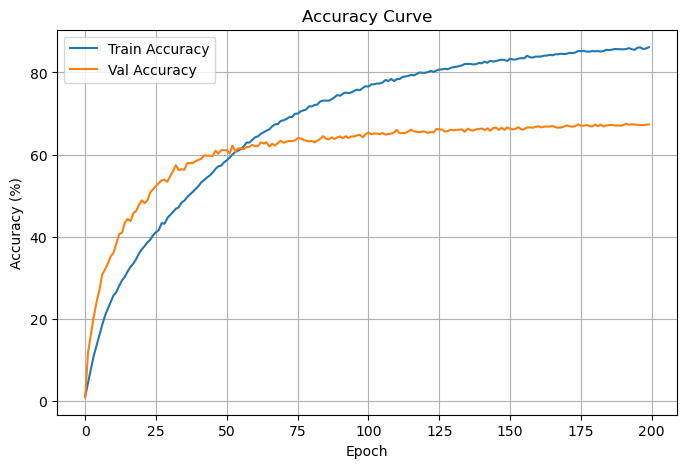

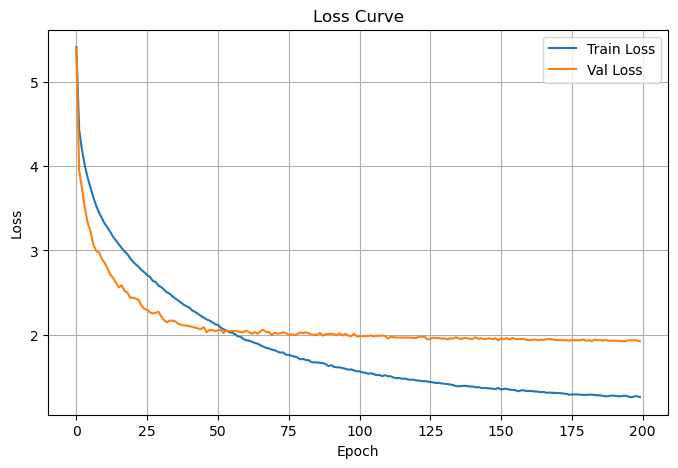

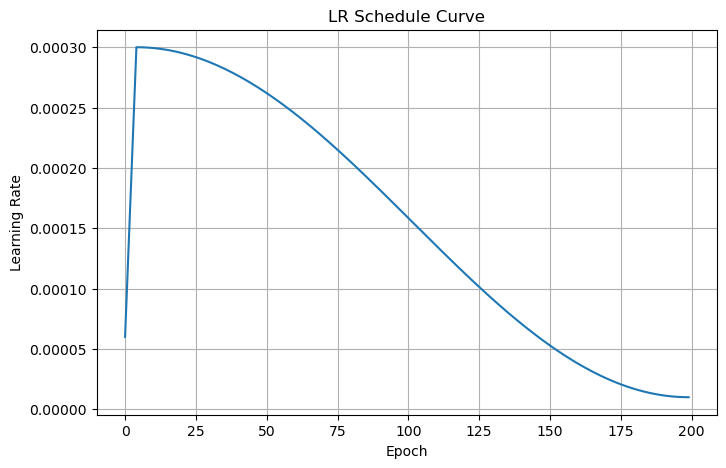

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("CTD_ViT_metrics.csv")

# Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(df["train_acc"], label="Train Accuracy")
plt.plot(df["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.savefig("CTD_ViT_accuracy_curve.png", dpi=300)
plt.show()

# Loss Curve
plt.figure(figsize=(8,5))
plt.plot(df["train_loss"], label="Train Loss")
plt.plot(df["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("CTD_ViT_loss_curve.png", dpi=300)
plt.show()

#  Learning Rate Schedule
plt.figure(figsize=(8,5))
plt.plot(df["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("LR Schedule Curve")
plt.grid(True)
plt.savefig("CTD_ViT_lr_curve.png", dpi=300)
plt.show()
